
# Python Implementation of Luke Barousse's SQL Data Analysis

Inspired by [Luke Barousse's SQL course for Data Analytics](https://www.lukebarousse.com/sql), this project replicates the analysis in Python. Using libraries like Pandas, NumPy, and Seaborn, we explore and visualize job postings data.


In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings


# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load datasets
jpf = pd.read_csv("job_postings_fact.csv")
cd = pd.read_csv("company_dim.csv")
sjd = pd.read_csv("skills_job_dim.csv")
sd = pd.read_csv("skills_dim.csv")

# Eliminate unnecessary columns from 'sd'
sd = sd[['skill_id', 'skills']]

# Convert job posted dates to datetime format
jpf['job_posted_date'] = pd.to_datetime(jpf['job_posted_date'])

## I. Data Analyst Job Postings with Highest Salaries

This analysis focuses on identifying the top-paying Data Analyst job postings. The dataset is filtered to include only full-time, remote positions and sorted by yearly average salary in descending order. Company names are joined from the company dimension table for better insights.


In [455]:
# Keep the original data intact
sample_df = (jpf.dropna(subset=['salary_year_avg'])  # Drop rows with NaN in 'salary_yearly_avg'
    .loc[
        (jpf['job_title_short'] == 'Data Analyst') &  # Filter for 'Data Analyst'
        (jpf['job_work_from_home'] == True) &       # Filter for work-from-home jobs
        (jpf['job_schedule_type'] == 'Full-time') # Filter for full-time jobs
        #(jpf['job_posted_date'].dt.year == 2023) # Filter for 2023
        ]
    ).sort_values('salary_year_avg', ascending=False)    # Sort from highest salary 

# Identify the relevant columns and display only the top-10 results       
sampletop_df = sample_df[['job_id', 'company_id', 'job_title_short', 'job_country', 'salary_year_avg']].head(10)  

#Eliminiate unneccessary columns
cd_name = cd[['company_id', 'name']] 

# Join the company dimension table to show the company name
merge_df = pd.merge(sampletop_df, cd_name, on='company_id', how='inner') 

# Identify the relevant columns and re-set the sorting
merge_df = merge_df[['name','job_id', 'job_title_short', 'job_country','salary_year_avg']].sort_values('salary_year_avg', ascending=False) 

### Visualizing Top 10 Companies by Average Data Analyst Salary

This analysis presents a horizontal bar chart showcasing the top 10 companies offering the highest average yearly salaries for Data Analyst positions. To enhance clarity:

1. Duplicate company names are distinguished with a suffix, e.g., "Company X (2)".
2. Salaries are displayed on each bar in a clean, currency format for better readability.
3. The chart is styled with a consistent color scheme and improved grid layout to emphasize the salary differences.

The visualization highlights the distribution of salaries across companies, making it easier to identify the highest-paying employers for Data Analyst roles.


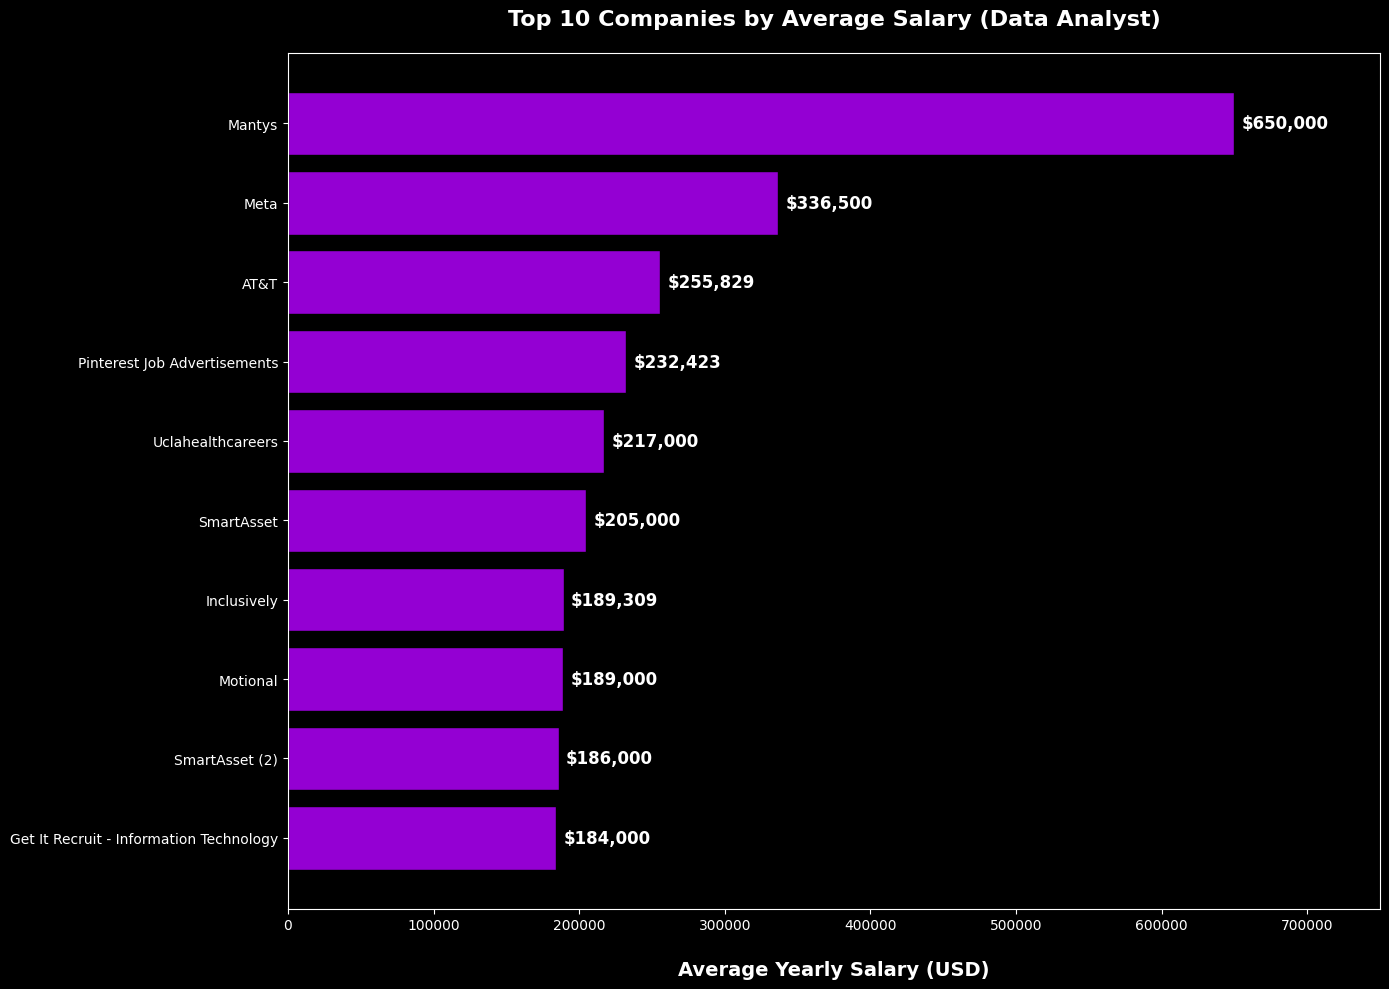

In [ ]:
# Sort merge_df by salary_year_avg in descending order
merge_df = merge_df.sort_values('salary_year_avg', ascending=False)

# Count the occurrences of each company in the 'name' column
merge_df['label'] = merge_df['name']

# Add suffix only for duplicate companies
merge_df['label'] = merge_df.groupby('name').cumcount().add(1).astype(str)
merge_df['label'] = merge_df.apply(lambda x: f"{x['name']} ({x['label']})" if int(x['label']) > 1 else x['name'], axis=1)

# Solid color for all bars
bar_color = 'darkviolet'

# Create a horizontal bar chart
plt.figure(figsize=(14, 10))
bars = plt.barh(
    merge_df['label'], merge_df['salary_year_avg'],
    color=bar_color,
    edgecolor='black'
)

# Add labels to each bar (formatted as currency without decimals)
for bar in bars:
    plt.text(
        bar.get_width() + 5000,  # Adjusted spacing for label
        bar.get_y() + bar.get_height() / 2,
        f"${int(bar.get_width()):,}",  # Format salary with commas and remove decimals
        va='center', fontsize=12, color='white', weight='bold'
    )

# Customize the plot
plt.title('Top 10 Companies by Average Salary (Data Analyst)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Average Yearly Salary (USD)', fontsize=14, weight='bold', labelpad=20)
plt.gca().invert_yaxis()  # Invert y-axis for easier readability

# Darken x-axis grid lines
plt.grid(axis='x', linestyle='-', linewidth=0.8, alpha=0.9, color='black')

# Extend x-axis to fit labels
plt.xlim(0, merge_df['salary_year_avg'].max() + 100000)

# Remove y-axis grid lines for cleaner appearance
plt.grid(axis='x', linestyle='', linewidth=0)

# Apply tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


## II. Identifying High-Demand Skills in Top Job Postings

This analysis focuses on finding the most in-demand skills among the top 10 highest-paying jobs:

1. **Linking Skills**: Joined job postings with skill IDs to identify required skills.  
2. **Counting Demand**: Counted how many job postings require each skill.  
3. **Filtering**: Removed skills demanded by only one job to highlight key trends.  
4. **Skill Names**: Replaced skill IDs with names for clarity.


In [459]:

skills_df = pd.merge(merge_df, sjd, on='job_id', how='inner') # Join the skills_job_dim table to be able to later join the skills_dim table which holds the skill name column
skills_df = skills_df.groupby('skill_id')['job_id'].count().sort_values(ascending=False).reset_index() # Find out the demand for each skills in the top 10 job postings
skills_df = skills_df.loc[skills_df['job_id'] > 1] # Get rid of those skills that are the least demanded
skills_df = pd.merge(skills_df, sd, on='skill_id', how='inner') # Join the skills_dim table to see the skills


### Visualization of Skills and Job Count with Adjusted Intensity

This horizontal bar chart displays the number of job postings for various skills, with a color gradient representing job count intensity. The chart uses a custom purple colormap to adjust the contrast and starts from a darker shade for better differentiation.


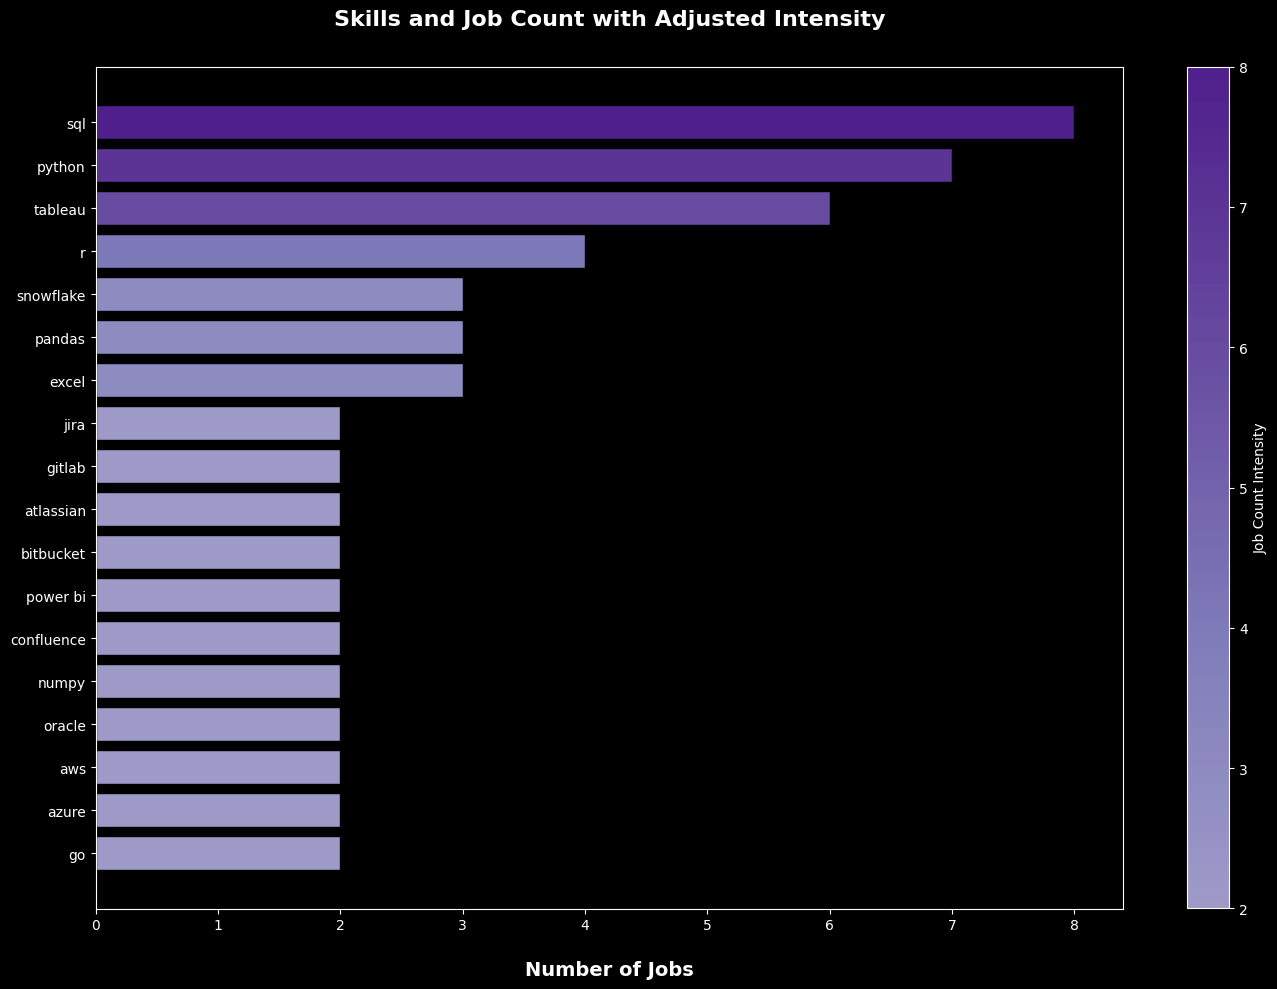

In [484]:
# Normalize job_id counts for coloring
norm = mcolors.Normalize(vmin=skills_df['job_id'].min(), vmax=skills_df['job_id'].max())

# Adjust the contrast to start from a darker shade
cmap = plt.cm.Purples  # Base colormap
cmap_custom = mcolors.LinearSegmentedColormap.from_list(
    "CustomPurples", cmap(np.linspace(0.5, 0.9, 256))  
)
colors = cmap_custom(norm(skills_df['job_id']))

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(14, 10))
bars = ax.barh(skills_df['skills'], skills_df['job_id'], color=colors, edgecolor='black')

# Add labels and title
ax.set_xlabel('Number of Jobs', fontsize=14, weight='bold', labelpad=20)  
ax.set_title('Skills and Job Count with Adjusted Intensity', fontsize=16, weight='bold', pad=30) 


# Invert y-axis for better visualization
ax.invert_yaxis()

# Show color bar linked to the same normalization
sm = plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm)
sm.set_array([])  # Remove the array data
cbar = plt.colorbar(sm, ax=ax, label='Job Count Intensity')

# Apply tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


## III. Most in-demand skills for Data Analysts

In this analysis, we identify the top 20 most in-demand skills from job postings and categorize them into custom demand levels for better interpretation.

1. **Filter Top Skills**: Extract the top 20 skills based on job posting counts.
2. **Custom Demand Groups**: 
   - Bin job posting counts into categories: `Low`, `Moderate`, `High`, and `Very High`.
   - Use custom bin edges to define ranges for each demand group.
3. **Resulting DataFrame**: Includes skill names, job counts, and their corresponding demand categories.


In [479]:
sample_df = sample_df[['job_id', 'company_id', 'job_title_short', 'job_country', 'salary_year_avg']]
skilldemand_df = pd.merge(sample_df, sjd, on='job_id', how='inner')
skilldemand_df = pd.merge(skilldemand_df, sd, on='skill_id', how='inner')
skilldemand_df = skilldemand_df.groupby('skills')['job_id'].count().sort_values(ascending=False).head(20).reset_index()

# Define custom bin edges and labels
custom_bins = [0, 35, 60, 200, float('inf')]  # Define the bin edges
demand_labels = ['Low', 'Moderate', 'High', 'Very High']  # Corresponding labels

# Create a new column with the custom skill demand groups
skilldemand_df['skill_demand_group'] = pd.cut(skilldemand_df["job_id"], bins=custom_bins, labels=demand_labels, include_lowest=True)

skilldemand_df


,skills,job_id,skill_demand_group
0,sql,377,Very High
1,excel,253,Very High
2,python,225,Very High
3,tableau,217,Very High
4,r,140,High
5,sas,120,High
6,power bi,101,High
7,powerpoint,57,Moderate
8,word,48,Moderate
9,looker,47,Moderate


### Visualizing Skill Demand Distribution by Group 

In this analysis, we filter out skills with "Low" demand and create a stacked bar chart to visualize the distribution of skills across various demand groups (Low, Moderate, High, Very High). The data is first pivoted to get counts for each skill demand group and then displayed with a custom colormap. Labels are added on each skill within the stacks for better clarity.

Key steps:
1. Filter out "Low" demand group.
2. Pivot data to get counts of skills by demand group.
3. Apply a custom colormap to emphasize the skill demand intensity.
4. Add skill labels within each bar stack to improve readability.
5. Customize the plot with a clear title, labels, and a clean layout.



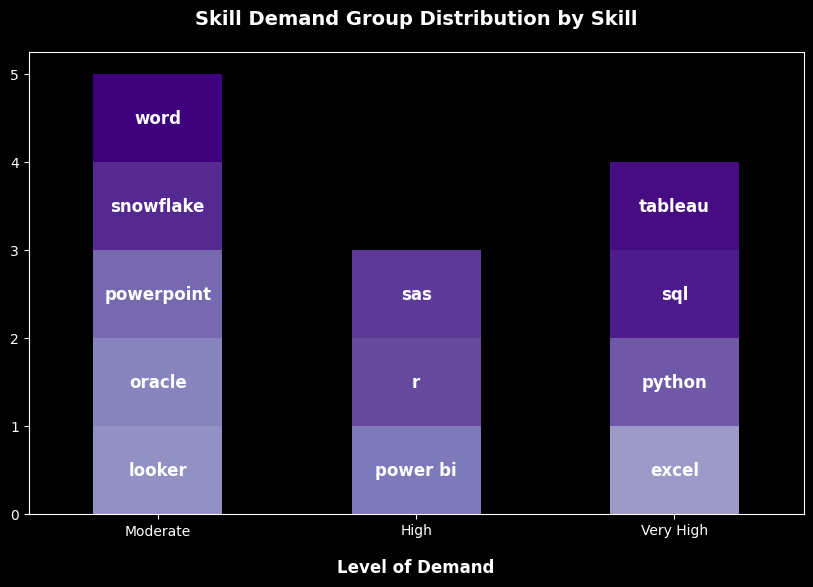

In [480]:
# Filter out the "Low" demand group from the original dataframe
skilldemand_df_filtered = skilldemand_df[skilldemand_df['skill_demand_group'] != 'Low']

# Pivot the data to get counts for each skill demand group
skill_demand_pivot = skilldemand_df_filtered.groupby(['skill_demand_group', 'skills']).size().unstack(fill_value=0)

# Drop the "Low" category from the pivot table
skill_demand_pivot = skill_demand_pivot.drop('Low', axis=0)

# Define a custom colormap to darken the darkest color
cmap = plt.cm.Purples
new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_blue", cmap(np.linspace(0.5, 1, 256)))

# Plotting the stacked bar chart with the custom colormap
ax = skill_demand_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), cmap=new_cmap, legend=False)

# Adding labels on the stacks (skills) within each bar
for j, skill in enumerate(skill_demand_pivot.index):  # Iterate over skill demand groups (rows)
    height_accumulated = 0  # Start from 0 for each row (demand group)
    for i, col in enumerate(skill_demand_pivot.columns):  # Iterate over skills (columns)
        val = skill_demand_pivot.loc[skill, col]
        if val > 0:
            # Place the label in the center of the current stack with white text color and larger font size
            ax.text(j, height_accumulated + val / 2, col, ha='center', va='center', fontsize=12, rotation=0, color='white', weight='bold')
            height_accumulated += val  # Accumulate height for the next skill in the stack

# Adding title and axis labels
plt.title('Skill Demand Group Distribution by Skill', fontsize=14, weight='bold', pad=20)
plt.xlabel('Level of Demand', fontsize=12, weight='bold', labelpad=15)


# Set the x-axis tick labels to the unique skill demand groups
plt.xticks(range(len(skill_demand_pivot.index)), [x for x in skill_demand_pivot.index], rotation=0)



# Show the plot
plt.show()


## IV. Top skills for Data Analyst based on salary

In this analysis, we identify the top 25 skills that are associated with the highest average yearly salary. The process involves merging relevant job and skill data, followed by grouping and sorting to find the highest-paying skills. 

Key steps:
1. Merge job postings data with skill information.
2. Calculate the average salary for each skill.
3. Sort the skills based on the average salary in descending order.



In [446]:
payingskills_df = sample_df.copy()
payingskills_df = pd.merge(payingskills_df, sjd, on='job_id', how='inner')
payingskills_df = pd.merge(payingskills_df, sd, on='skill_id', how='inner')
payingskills_df = payingskills_df.reset_index()
payingskillsresult_df = payingskills_df.groupby('skills')['salary_year_avg'].mean().round(0).reset_index().sort_values('salary_year_avg', ascending=False).head(25)
payingskillsresult_df = payingskillsresult_df.reset_index()
payingskillsresult_df

,index,skills,salary_year_avg
0,70,pyspark,208172.0
1,8,bitbucket,189154.0
2,16,couchbase,160515.0
3,109,watson,160515.0
4,20,datarobot,155486.0
5,32,gitlab,154500.0
6,98,swift,153750.0
7,42,jupyter,152776.0
8,60,pandas,151821.0
9,34,golang,145000.0


### Visualization of Top 25 Skills by Average Yearly Salary

This horizontal bar chart displays the top 25 skills by their average yearly salary. The bars are colored based on salary intensity, with a custom purple colormap to emphasize higher salaries. Labels are added to each bar, displaying the exact salary value formatted as currency.


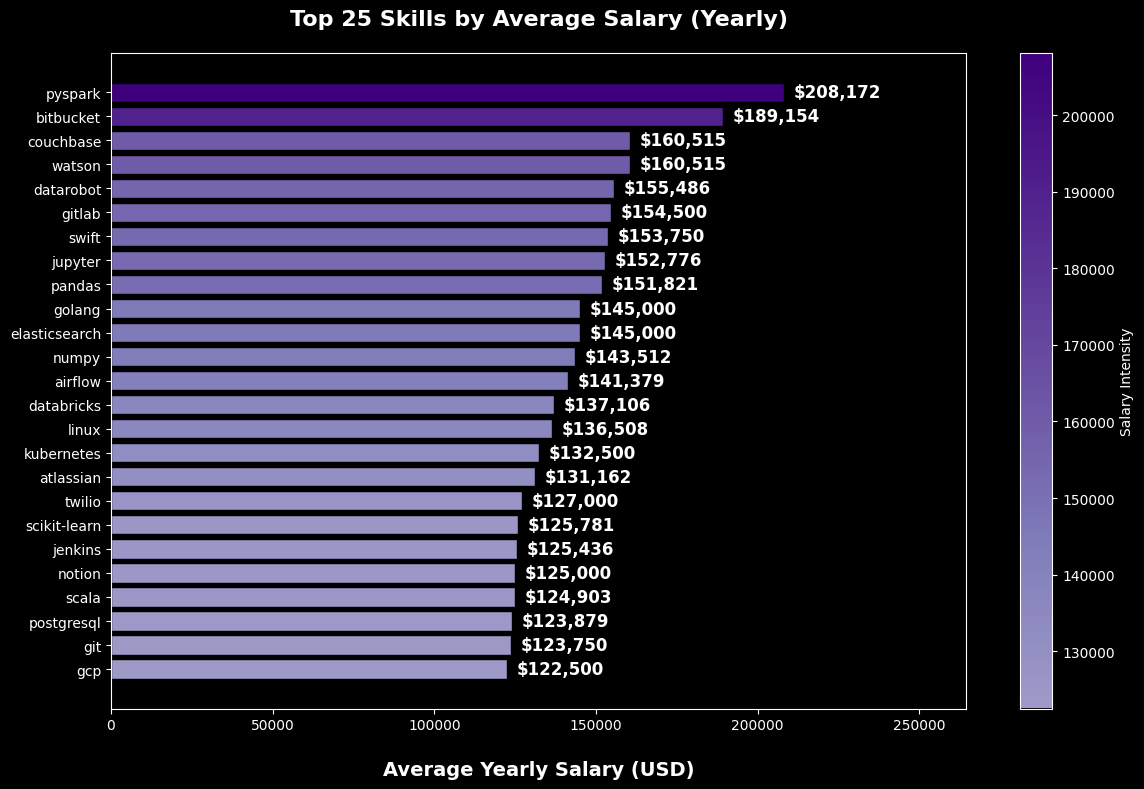

In [476]:
# Set the dark grey background for the plot
plt.style.use('dark_background')

# Normalize the salary values for coloring
norm = mcolors.Normalize(vmin=payingskillsresult_df['salary_year_avg'].min(), vmax=payingskillsresult_df['salary_year_avg'].max())
cmap = plt.cm.Purples  # Base colormap
new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_purple", cmap(np.linspace(0.5, 1, 256)))

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(payingskillsresult_df['skills'], payingskillsresult_df['salary_year_avg'], 
               color=new_cmap(norm(payingskillsresult_df['salary_year_avg'])), edgecolor='black')

# Add labels to each bar (formatted as currency without decimals)
for bar in bars:
    ax.text(
        bar.get_width() + 3000,  # Adjusted spacing for label
        bar.get_y() + bar.get_height() / 2,
        f"${int(bar.get_width()):,}",  # Format salary with commas and remove decimals
        va='center', fontsize=12, color='white', weight='bold'
    )

# Customize the plot with bold titles and labels
ax.set_title('Top 25 Skills by Average Salary (Yearly)', fontsize=16, weight='bold', color='white', pad=20)
ax.set_xlabel('Average Yearly Salary (USD)', fontsize=14, weight='bold', color='white', labelpad=20)


# Invert y-axis for better readability
ax.invert_yaxis()

# Add a color bar for the salary intensity
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])  # Remove the array data
cbar = plt.colorbar(sm, ax=ax, label='Salary Intensity')

# Extend x-axis to fit labels
plt.xlim(0, merge_df['salary_year_avg'].mean())


# Apply tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


# V. Optimal skills: high-paying and high-demand


In this analysis, we calculate the average yearly salary and job demand for each skill. We first group the data by skill and compute the average salary and job count (demand). Then, we filter out skills with fewer than 20 job postings and sort the results by the average salary in descending order.


In [481]:
# Find out the average salary and demand for each skill
optimalskills_df = payingskills_df.copy()
optimalskills_df = optimalskills_df.groupby('skills').agg(
    salary_year_avg=('salary_year_avg', 'mean'),
    job_count=('job_id', 'size')
).reset_index()
optimalskills_df = optimalskills_df[optimalskills_df['job_count'] > 20]
optimalskills_df = optimalskills_df.sort_values('salary_year_avg', ascending=False)
optimalskills_df

,skills,salary_year_avg,job_count
35,hadoop,116916.023810,21
33,go,113363.145833,24
88,snowflake,112947.972973,37
4,aws,111953.568966,29
5,azure,109359.790323,31
45,looker,105956.797872,47
58,oracle,103062.414062,36
71,python,102017.795139,225
73,r,101423.970759,140
100,tableau,99455.935484,217


### Bubble Chart: Skills vs Job Count with Average Salary

In this visualization, a bubble chart is created to show the relationship between skills, average salary, and job count. The size of the bubbles corresponds to the job count, while the color represents the skill's base color, darkened by 30% for a more professional look. Labels are added to each bubble to display the skill names, and the background is set to dark grey for better contrast.


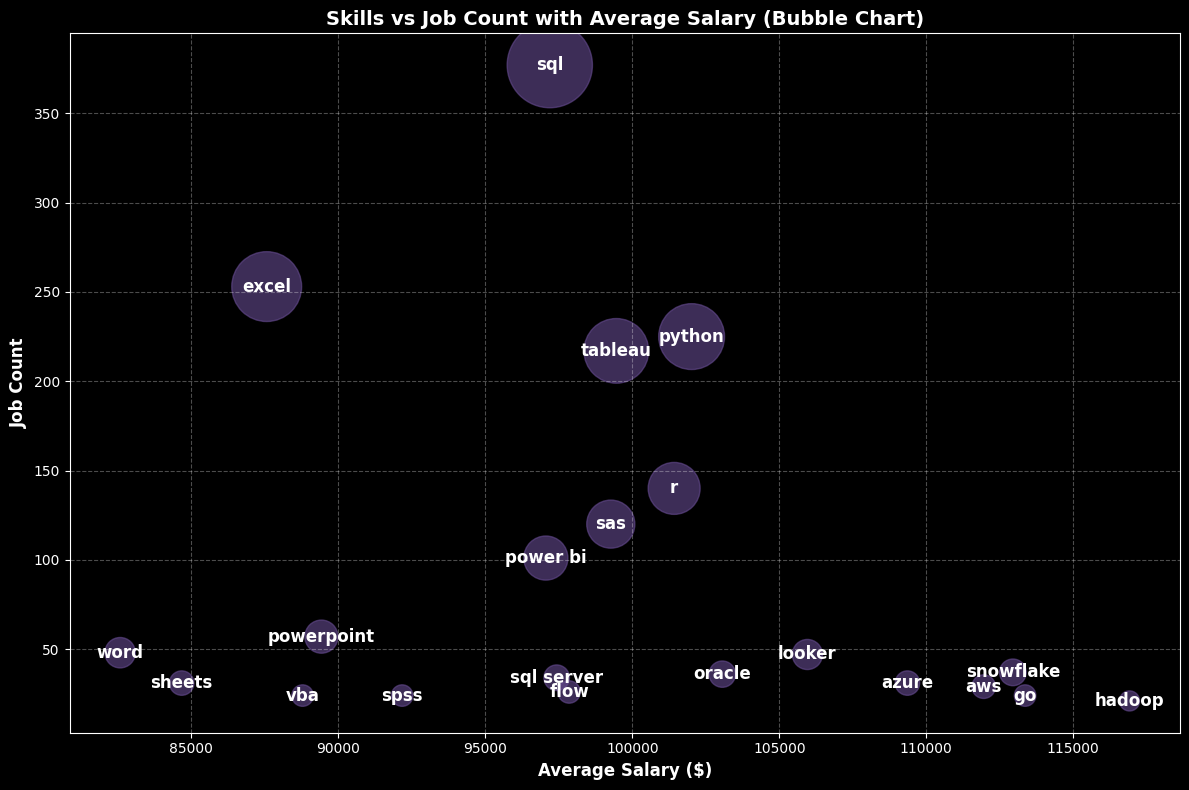

In [483]:
# Set the dark grey background for the plot
plt.style.use('dark_background')

# Create a bubble chart
plt.figure(figsize=(12, 8))

# Define the base color (light blue)
base_color = mcolors.to_rgba('#936dd1')

# Adjust the color to be darker while keeping the same hue
darker_color = (base_color[0] * 0.7, base_color[1] * 0.7, base_color[2] * 0.7, base_color[3])  # Darken by 30%

# Plot the bubble chart with the size of the bubbles corresponding to job_count
scatter = plt.scatter(optimalskills_df['salary_year_avg'], optimalskills_df['job_count'],
                      s=optimalskills_df['job_count']*10,  # Scale the size of the bubbles
                      color=darker_color, alpha=0.6)

# Add labels for each dot (skill name), with white text color, bold, centered, and larger
for i, row in optimalskills_df.iterrows():
    plt.text(row['salary_year_avg'], row['job_count'], row['skills'], 
             fontsize=12, ha='center', va='center', color='white', weight='bold')

# Adding labels and title with white text
plt.xlabel('Average Salary ($)', fontsize=12, color='white', weight='bold')
plt.ylabel('Job Count', fontsize=12, color='white', weight='bold')
plt.title('Skills vs Job Count with Average Salary (Bubble Chart)', fontsize=14, color='white', weight='bold')

# Adding gridlines for better readability
plt.grid(True, linestyle='--', color='white', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
